In [158]:
#import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

In [160]:
df_motion = pd.read_csv('clustering_columns.csv')

In [162]:
df_motion = df_motion.drop('position',axis=1)

In [164]:
# #get dummy variables for non-numeric columns

# df_motion = pd.get_dummies(df_motion, columns=['position'], drop_first=False, dtype='int')

In [166]:
from sklearn.preprocessing import StandardScaler

#standardize the variables before conducting PCA
scaler = StandardScaler()
scaler.fit(df_motion)
df_motion_scaled = scaler.transform(df_motion)

In [168]:
#PCA
from sklearn.decomposition import PCA
pca = PCA(random_state=42)

In [170]:
pca.fit(df_motion_scaled)

PCA(random_state=42)

In [172]:
# Perform PCA (already done in your code)
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance)
print("Total Variance Explained:", np.sum(explained_variance))

Explained Variance Ratio: [3.12024722e-01 1.61164074e-01 1.23655042e-01 9.69817329e-02
 8.58975696e-02 7.10570152e-02 5.13054655e-02 4.52372800e-02
 3.11146205e-02 1.57299804e-02 5.80642715e-03 2.60698704e-05
 1.72949567e-17 0.00000000e+00 0.00000000e+00]
Total Variance Explained: 0.9999999999999999


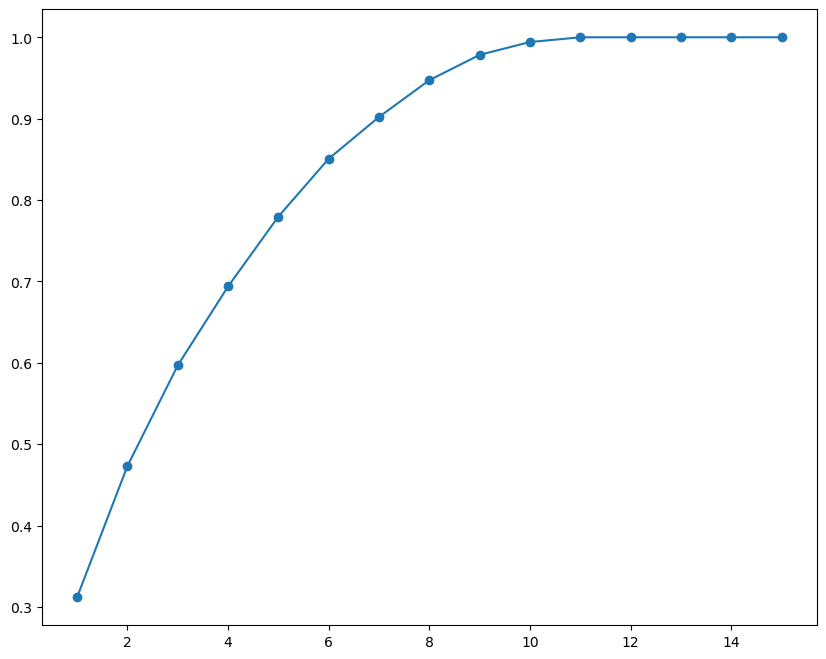

In [174]:
plt.figure(figsize = (10,8))
plt.plot(range(1,16), pca.explained_variance_ratio_.cumsum(), marker = 'o')

In [176]:
#to preserve ~80% of variance, set n_components=5
pca = PCA(n_components=6, random_state=42)
pca.fit(df_motion_scaled)

PCA(n_components=6, random_state=42)

In [178]:
x_pca = pca.transform(df_motion_scaled)

100%|██████████| 50/50 [00:30<00:00,  1.63it/s]


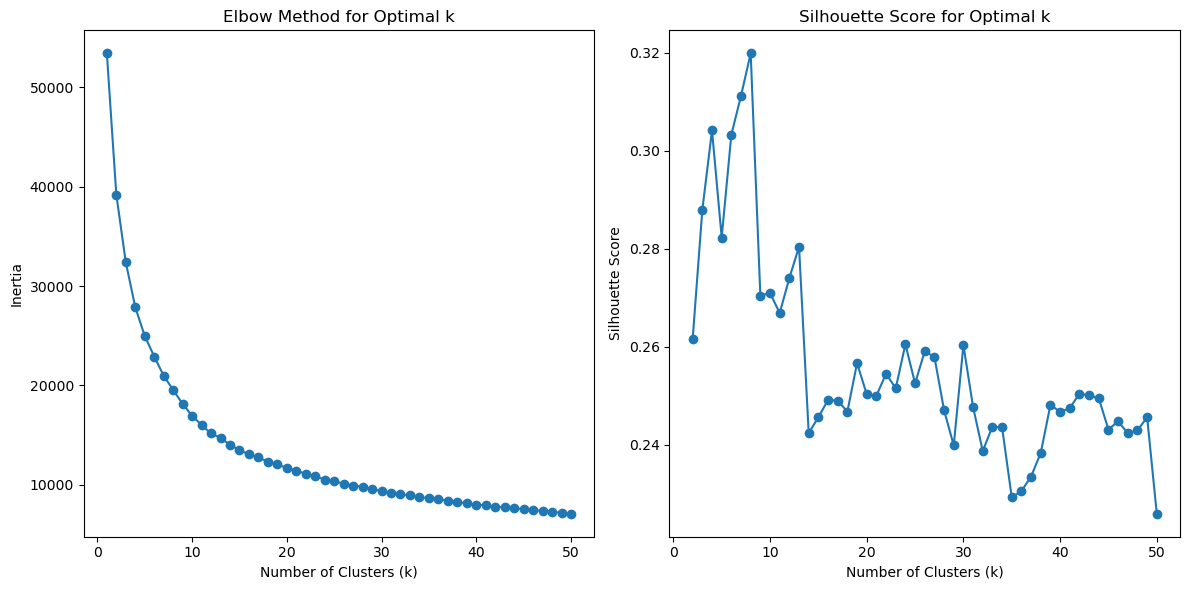

In [180]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")

# Define a range of k values to try
k_range = range(1, 51)  # Trying k values from 1 to 50

# For storing inertia and silhouette scores
inertia = []
sil_scores = []

# Loop through each value of k
for k in tqdm(k_range):
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(x_pca)  # Use your PCA-transformed data (x_pca)

    # Compute inertia for Elbow Method
    inertia.append(kmeans.inertia_)

    # Compute silhouette score
    if k > 1:  # Silhouette score is only defined for k > 1
        sil_score = silhouette_score(x_pca, labels)
        sil_scores.append(sil_score)
    else:
        sil_scores.append(-1)  # For k=1, silhouette score is undefined


# Plot the Elbow Method (Inertia vs. k)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')

# Plot the Silhouette Scores (Silhouette Score vs. k)
plt.subplot(1, 2, 2)
plt.plot(k_range[1:], sil_scores[1:], marker='o')  # Skip the first value (k=1)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')

plt.tight_layout()
plt.show()


In [182]:
#use n=30
cluster_num = 30
kmeans = KMeans(n_clusters=cluster_num, random_state=42)  # Adjust clusters as needed
labels = kmeans.fit_predict(x_pca)

In [184]:
kmeans.labels_

array([24, 25,  0, ..., 23,  2,  0])

In [186]:
#set labels as a column in original df

In [188]:
df_player_play_motion = pd.read_csv('df_player_play_motion.csv')

In [190]:
df_player_play_motion['motion_label'] = kmeans.labels_

In [192]:
df_player_play_motion.head()

,gameId,playId,nflId,teamAbbr,hadRushAttempt,rushingYards,hadDropback,passingYards,sackYardsAsOffense,hadPassReception,...,x_dis_travel_pos,x_dis_travel_neg,x_move_ratio,y_dis_travel_pos,y_dis_travel_neg,y_flipped,swapped_y_dir,position,swapped_side,motion_label
0,2022090800,80,47857,BUF,0,0,0,0,0,0,...,2,411,0.004843,288,1071,1,1,RB,0,24
1,2022090800,101,53079,BUF,0,0,0,0,0,0,...,240,28,0.895522,211,539,1,1,FB,1,25
2,2022090800,191,53079,BUF,0,0,0,0,0,0,...,76,6,0.926829,71,4,1,0,FB,0,0
3,2022090800,236,52536,BUF,0,0,0,0,0,1,...,31,12,0.720930,0,474,1,0,WR,0,22
4,2022090800,299,43399,LA,0,0,0,0,0,0,...,178,47,0.791111,24,514,0,0,TE,1,1


In [194]:
# Create a dictionary to hold DataFrames for each unique motion_label
motion_label_dfs = {label: df_player_play_motion[df_player_play_motion['motion_label'] == label]
                     for label in df_player_play_motion['motion_label'].unique()}

In [196]:
# Get the row size of every DataFrame in motion_label_dfs
row_sizes = {label: df.shape[0] for label, df in motion_label_dfs.items()}
# Print the row sizes in numerical order, one per line
for label, size in sorted(row_sizes.items(), key=lambda item: item[1]):
    print(f'Motion Label: {label}, Row Size: {size}')

##CHECK THE MOTIONS WITH ONLY 2 IN THE GROUP, LIKELY OUTLIERS THAT CAN BE CUT

Motion Label: 27, Row Size: 4
Motion Label: 3, Row Size: 44
Motion Label: 28, Row Size: 47
Motion Label: 10, Row Size: 52
Motion Label: 6, Row Size: 58
Motion Label: 19, Row Size: 61
Motion Label: 5, Row Size: 64
Motion Label: 14, Row Size: 66
Motion Label: 13, Row Size: 74
Motion Label: 18, Row Size: 79
Motion Label: 8, Row Size: 88
Motion Label: 23, Row Size: 94
Motion Label: 24, Row Size: 100
Motion Label: 12, Row Size: 103
Motion Label: 26, Row Size: 122
Motion Label: 25, Row Size: 130
Motion Label: 11, Row Size: 135
Motion Label: 29, Row Size: 138
Motion Label: 1, Row Size: 148
Motion Label: 21, Row Size: 159
Motion Label: 4, Row Size: 175
Motion Label: 9, Row Size: 177
Motion Label: 17, Row Size: 211
Motion Label: 7, Row Size: 233
Motion Label: 16, Row Size: 236
Motion Label: 0, Row Size: 267
Motion Label: 20, Row Size: 283
Motion Label: 15, Row Size: 307
Motion Label: 22, Row Size: 390
Motion Label: 2, Row Size: 439


In [198]:
#example

motion_category = 2

motion_label_dfs[motion_category][:20]

,gameId,playId,nflId,teamAbbr,hadRushAttempt,rushingYards,hadDropback,passingYards,sackYardsAsOffense,hadPassReception,...,x_dis_travel_pos,x_dis_travel_neg,x_move_ratio,y_dis_travel_pos,y_dis_travel_neg,y_flipped,swapped_y_dir,position,swapped_side,motion_label
23,2022090800,1187,43399,LA,0,0,0,0,0,0,...,104,53,0.662420,24,791,1,0,TE,1,2
53,2022090800,3092,43399,LA,0,0,0,0,0,0,...,49,72,0.404959,2,1119,0,0,TE,1,2
56,2022090800,3304,48011,BUF,0,0,0,0,0,0,...,102,52,0.662338,4,1144,1,0,TE,1,2
57,2022090800,3674,43399,LA,0,0,0,0,0,0,...,73,87,0.456250,2,1043,0,0,TE,1,2
66,2022091100,233,53433,ATL,0,0,0,0,0,0,...,70,54,0.564516,56,904,1,0,TE,1,2
71,2022091100,501,52942,NO,0,0,0,0,0,0,...,124,51,0.708571,5,970,0,0,TE,1,2
78,2022091100,914,41808,ATL,0,0,0,0,0,0,...,17,38,0.309091,6,1003,0,0,FB,1,2
85,2022091100,1067,41808,ATL,0,0,0,0,0,0,...,22,44,0.333333,34,1288,1,0,FB,1,2
88,2022091100,1170,52513,NO,0,0,0,0,0,0,...,172,21,0.891192,7,943,0,0,TE,1,2
116,2022091100,2491,52942,NO,0,0,0,0,0,0,...,44,52,0.458333,0,976,1,0,TE,1,2


Notes on each category:
- (2) Wideout swaps sides
- (23) Wideout runs into tackle box as ball is snapped
- ()

Observations on the results
- Doesn't seem to care if a player runs back and forth, for example: [2022091100, 166]
- Might be useful to add distance from QB to this (distinguish between starting in backfield, lined up outside etc.) Tried to do with line but maybe didn't work great

In [91]:
df_player_play_motion[(df_player_play_motion['gameId'] == 2022091100) & (df_player_play_motion['playId'] == 1413)]

,gameId,playId,nflId,teamAbbr,hadRushAttempt,rushingYards,hadDropback,passingYards,sackYardsAsOffense,hadPassReception,...,motion_s_avg,frames_in_motion,y_reverse_loc,y_reverse_bool,y_dis_travel_pos,y_dis_travel_neg,y_flipped,swapped_directions,swapped_side,motion_label
113,2022091100,1413,52942,NO,0,0,0,0,0,0,...,289.818182,33,503.0,1,363,587,0,1,0,2


In [ ]:
#Export labels for every motion
df_player_play_motion.to_csv('player_play_motion_labels.csv',index=False)

#Create a short description for all categories for the reader

In [ ]:
# see how starting side / motion type affects run percentage